This notebook shows pre-processing part of OCR recognition

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import argparse
from PIL import Image
from PIL import ImageFilter
from pylab import *

First step is to insert image

In [28]:
img = Image.open('./textArea01.png')

In [29]:
kernel1 = np.array([[-1,-1,-1],[2, 2, 2],[-1, -1, -1]])
kernel2 = np.array([[-1, 2,-1],[-1, 2, -1],[-1, 2, -1]])
kernel3 = np.array([[2,-1,-1],[-1, 2, -1],[-1, -1, 2]])
kernel4 = np.array([[-1,-1,2],[-1, 2, -1],[2, -1, -1]])

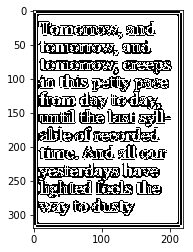

In [7]:
#http://stackoverflow.com/questions/34981144/split-text-lines-in-scanned-document
img = np.asarray(img)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(th3,'gray')
plt.show()

In [24]:
#http://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
image = cv2.imread("./skew2.png")
#image = cv2.imread("C:\Users\Franjo\Documents\FER\DOAS\DOAS - Projekt\cover.png")

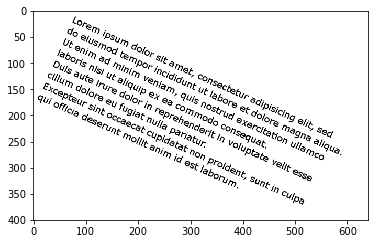

In [25]:
plt.imshow(image,"gray")
plt.show()

BINARISATION

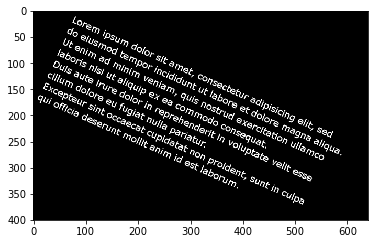

In [19]:
# convert the image to grayscale and flip the foreground
# and background to ensure foreground is now "white" and
# the background is "black"
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
 
# threshold the image, setting all foreground pixels to
# 255 and all background pixels to 0
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(gray,'gray')
plt.show()

CALCULATING ANGLE

In [20]:
# grab the (x, y) coordinates of all pixel values that
# are greater than zero, then use these coordinates to
# compute a rotated bounding box that contains all
# coordinates
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
 
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
    angle = -(90 + angle)

# otherwise, just take the inverse of the angle to make
# it positive
else:
    angle = -angle

ROTATING IMAGE

In [21]:
# rotate the image to deskew it
(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

In [22]:
# draw the correction angle on the image so we can validate it
cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
# show the output image
print("[INFO] angle: {:.3f}".format(angle))
cv2.imshow("Input", image)
cv2.imshow("Rotated", rotated)
cv2.waitKey(0)

[INFO] angle: 23.720


-1

In [36]:
#http://stackoverflow.com/questions/4632174/what-processing-steps-should-i-use-to-clean-photos-of-line-drawings
#grey = im.convert('L')
#im = Image.open(r'c:\temp\temp.png')
#image=Image.fromarray(image)
"""
white = image.filter(ImageFilter.BLUR).filter(ImageFilter.MaxFilter(15))
print gray.shape
width,height = gray.shape
impix = image
whitepix = white
greypix = grey.load()
for y in range(height):
    for x in range(width):
        greypix[x,y] = min(255, max(255 * impix[x,y][0] / whitepix[x,y][0], 255 * impix[x,y][2] / whitepix[x,y][3], 255 * impix[x,y][4] / whitepix[x,y][5]))
        """

'\nwhite = image.filter(ImageFilter.BLUR).filter(ImageFilter.MaxFilter(15))\nprint gray.shape\nwidth,height = gray.shape\nimpix = image\nwhitepix = white\ngreypix = grey.load()\nfor y in range(height):\n    for x in range(width):\n        greypix[x,y] = min(255, max(255 * impix[x,y][0] / whitepix[x,y][0], 255 * impix[x,y][2] / whitepix[x,y][3], 255 * impix[x,y][4] / whitepix[x,y][5]))\n        '

LINE REMOVAL

In [30]:
img=rotated
laplacian = cv2.Laplacian(img,cv2.CV_8UC1) # Laplacian OR
edges = cv2.Canny(img,80,10,apertureSize = 3) # canny Edge OR
# Output dtype = cv2.CV_8U # Sobel
sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
# Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)

# Hough's Probabilistic Line Transform 
minLineLength = 900
maxLineGap = 100
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
if lines != None:
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)

cv2.imshow("Input", img)
cv2.waitKey(0)

-1